In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Create an ImageDataGenerator with specified augmentations
datagen = ImageDataGenerator(
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.2,         # Randomly zoom images (range: 0.2 means 20% zoom in/out)
    shear_range=0.2        # Randomly shear images
)

# Load your dataset using tf.keras.utils.image_dataset_from_directory
data = tf.keras.utils.image_dataset_from_directory('photos', batch_size=400)

# Create lists to store augmented images and labels
augmented_images = []
augmented_labels = []

# Loop through each batch of data
for images, labels in data:
    # Loop through each image in the batch
    for i in range(len(images)):
        image_np = images[i].numpy()  # Convert TensorFlow tensor to NumPy array
        augmented_images.append(image_np)  # Original image
        augmented_labels.append(labels[i])

        # Apply data augmentation multiple times (e.g., 3 times)
        for _ in range(5):
            augmented_image = datagen.random_transform(image_np)
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])

# Convert lists to NumPy arrays and normalize
augmented_images = np.array(augmented_images) / 255.0
augmented_labels = np.array(augmented_labels)

# Create a new dataset with augmented data
augmented_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

# Shuffle the dataset and set batch size
augmented_data = augmented_data.shuffle(len(augmented_images))


Found 507 files belonging to 2 classes.


In [3]:
num_images = len(augmented_images)
num_classes = len(np.unique(augmented_labels))
print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")

Number of images: 3042
Number of classes: 2


In [4]:
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(16, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
# Implement learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

# Add model checkpointing
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

hist = model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[EarlyStopping(patience= 2, restore_best_weights=True), lr_schedule, checkpoint_cb])

Epoch 1/50
61/61 [==============================] - 32s 478ms/step - loss: 0.5865 - accuracy: 0.6958 - val_loss: 0.5402 - val_accuracy: 0.7084 - lr: 1.0000e-04
Epoch 2/50


E:\Code\Anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 24s 402ms/step - loss: 0.4695 - accuracy: 0.7790 - val_loss: 0.4369 - val_accuracy: 0.8090 - lr: 1.1220e-04
Epoch 3/50
61/61 [==============================] - 25s 406ms/step - loss: 0.3796 - accuracy: 0.8381 - val_loss: 0.3924 - val_accuracy: 0.8316 - lr: 1.2589e-04
Epoch 4/50
61/61 [==============================] - 25s 409ms/step - loss: 0.3289 - accuracy: 0.8607 - val_loss: 0.3527 - val_accuracy: 0.8419 - lr: 1.4125e-04
Epoch 5/50
61/61 [==============================] - 29s 472ms/step - loss: 0.3100 - accuracy: 0.8633 - val_loss: 0.4132 - val_accuracy: 0.8111 - lr: 1.5849e-04
Epoch 6/50
61/61 [==============================] - 21s 347ms/step - loss: 0.2504 - accuracy: 0.8998 - val_loss: 0.3216 - val_accuracy: 0.8563 - lr: 1.7783e-04
Epoch 7/50
61/61 [==============================] - 21s 345ms/step - loss: 0.2643 - accuracy: 0.8869 - val_loss: 0.3363 - val_accuracy: 0.8480 - lr: 1.9953e-04
Epoch 8/50
61/61 [==============================] -

In [8]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

20/20 - 2s - loss: 0.2356 - accuracy: 0.8966 - 2s/epoch - 79ms/step
Test accuracy: 0.8965517282485962


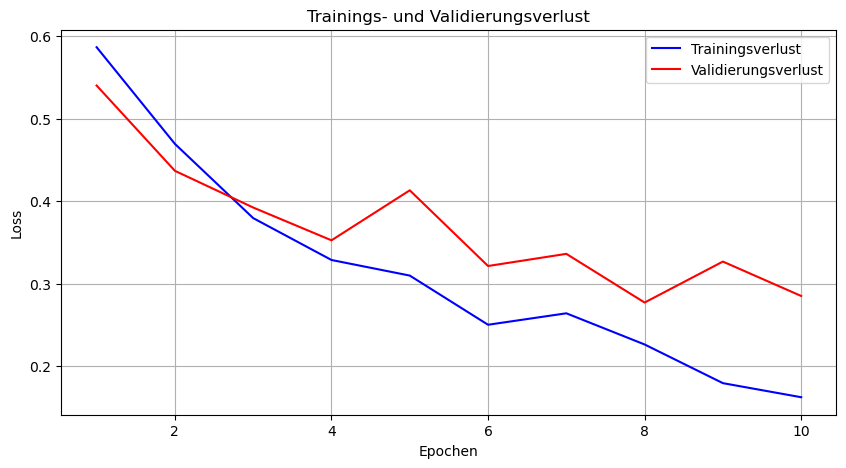

In [9]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Trainingsverlust')
plt.plot(epochs, val_loss, 'r', label='Validierungsverlust')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()